# -----
# FIG 6 in RECCAP SO paper, part 2 (maps in panels d-u)
# -----
# also included: Fig. S9
#
# Plot season of maximum CO2 uptake (maps)
# 
# Contact: cara.nissen@awi.de or cara.nissen@colorado.edu
#
# version: August 2023
#

In [1]:
### modules
import os
import numpy as np
import seawater as sw
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm 
from datetime import date, timedelta
import copy
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from annualmean import annualmean
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [2]:
#-----
# SETTINGS
# define paths to all data
# define where to save plots (if any)
# define years to average over
#-----

# data sets
path1 = '/pscratch/sd/c/cnissen/RECCAPv2/'
path_models = path1+'reccap_submissions/download_20220124/Models/2D_CO2/' 
path_data   = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_atminv = path1+'reccap_submissions/download_20220124/Atmospheric_inversions/'
path_soccom = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_trend  = path1+'reccap_submissions/download_20220124/Models/Linear_trends/' 

# river flux adjustment
path_river  = path1+'masks_reccap/river_flux_adjustment/'

# path to RECCAP SO mask
path_mask = path1+'masks_reccap/'

#----
# specify years to average over
#----
# NOTE: the script is written to plot avrages over 1985-2018
#    the years are defined here for plot titles and filenames 
year1,year2 = 1985,2018 
eval_time   = np.arange(year1,year2+1) 

#----
# define simulation
#----
sim = 'A'

#----
# define where to save plots
#----
save_to_dir ='/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig_6/maps_season_of_max_uptake/'
if not os.path.exists(save_to_dir):
    print ('Created '+save_to_dir)
    os.makedirs(save_to_dir)
    

In [3]:
#-----
# define data sets to consider
#-----
# NOTE: there is 6 different atm. inversions in the provided file, only load the ones that start in 1990 
# NOTE: AOML has to be the first in the list! there is a few places where the exclusion of AOML is 
# hard-coded as "[1:]"

# variable name of interest
var = '2D_CO2'

models     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
models2     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SO-ETHZ') 
ind_mpi = models.index("MPIOM-HAMOCC")
ind_not_mpi = [i for i, s in enumerate(models) if 'MPIOM-HAMOCC' not in s]
print ('Index of MPI:',ind_mpi)
print ('All inidces except MPI:',ind_not_mpi)
data_assim  = ('BSOSE','ECCO-Darwin')
data_ocim   = ('OCIM-v2014-CTL','OCIM-v2021')
data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv4']  #'Atm_inv3','Atm_inv5','Atm_inv6' -> start later than 1990
#data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv3','Atm_inv4','Atm_inv5','Atm_inv6'] # for 2015-2018, consider all 6
data_prod   = ('AOML_EXTRAT','CMEMS-LSCE-FFNN','CSIRML6','JenaMLS','JMAMLR',\
             'LDEO-HPD','NIES-ML3','OceanSODAETHZ','SOMFFN') 
data_watson = ['UOEX_Wat20']
soccom      = ('SOCCOM_Jena','SOCCOM_SOMFFN')

versionID_models     = ('20211125','v20211122','v20211208','v20220323','v20211119','v20211119',\
                       'v20220125','v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 
versionID_data_assim  = ('I134','v20210712')
versionID_data_ocim   = ('v20210607','v20210511')
versionID_data_atminv = ['v20211008']
versionID_data_prod   = ('v20211130','v20210709','v20211117','v20211126','v20211208',\
                       'v20211210','v20220222','v20211207','v20211121')
versionID_data_watson = ['v20211204']

# list of filenames for data products
filename_data_prod = ('fgco2_AOML_EXTRAT_1997-2020_v20211018.nc4',\
                      'fgco2_CMEMS-LSCE-FFNN_1985-2018_v20210709.nc',\
                      'fgco2_CSIRML6_1985-2018_v20211117.nc',\
                      'fgco2_JenaMLS_1985-2018_v20211126.nc',\
                      'fgco2_JMAMLR_1985-2019_v20211208.nc',\
                      'fgco2_LDEO_HPD_1985-2018_v20211210.nc',\
                      'fgco2_NIES-ML3_1980-2020_v20220222.nc',\
                      'fgco2_OceanSODAETHZ_1985-2018_v20211207.nc',\
                      'fgco2_MPI_SOMFFN_1982-2019_v20211121.nc')
filename_data_watson = ['fgco2_UOEX_Wat20_1985-2019_v20211204.nc']

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')   

print ('Models:',len(models),len(versionID_models))
print ('Data products:',len(data_prod),len(filename_data_prod))
print ('Data Watson2020:',len(data_watson),len(versionID_data_watson))
print ('Data assimilating models:',len(data_assim),len(versionID_data_assim))
print ('Data OCIM:',len(data_ocim),len(versionID_data_assim))
print ('Data ATM inversion:',len(data_atminv),len(versionID_data_atminv))


Index of MPI: 7
All inidces except MPI: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
Models: 14 14
Data products: 9 9
Data Watson2020: 1 1
Data assimilating models: 2 2
Data OCIM: 2 2
Data ATM inversion: 3 1


In [4]:
#----
# FUNCTIONS
#----

# transform longitude (e.g., go from -179.5:179.5 to 0.5:359.5)
def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    # for 3D arrays: assume lon coordinate to be the 3rd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180] 
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        try:
            data_transformed[:,:,0:180] = data[:,:,180:]
            data_transformed[:,:,180:]  = data[:,:,0:180]
        except:
            data_transformed[:,0:180,:] = data[:,180:,:]
            data_transformed[:,180:,:]  = data[:,0:180,:] 
    elif len(data.shape)==4:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180,:,:] = data[:,180:,:,:]
        data_transformed[:,180:,:,:]  = data[:,0:180,:,:] 
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    return data_transformed


In [5]:
#------
# load RECCAP mask for SO
# make sure region mask matches the submitted products in terms of longitude!
#------

# SO RECCAP regions
#reccap_mask_SO   = Dataset(path_mask+'RECCAP2_region_masks_all_v20221025.nc')
#regions          = reccap_mask_SO_2.variables['southern'][:,:] #"1.SO STSS, 2.SO SPSS, 3.SO ICE"
#lon_regions      = reccap_mask_SO_2.variables['lon'][:]
#print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)
#print(np.min(regions_2),np.max(regions_2))

# SO RECCAP regions
reccap_mask_SO = Dataset(path_mask+'reccap_regions_SOsubs.nc')
regions        = reccap_mask_SO.variables['SO_basins_biomes'][:,:]
lon_regions    = reccap_mask_SO.variables['lon'][:]
print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)

# lon in file is -180:180 -> want 0-360, so transform here
regions = transform_lon_coord(regions)
print(np.min(regions),np.max(regions))


-179.5 179.5
0.0 8.0


In [6]:
#-----
# load data
#-----

years_in_file = np.arange(1980,2018+1)

#-----
# LDEO
#-----
flux_data_ldeo = np.nan*np.ones([180,360,12,1])
for ii in range(0,1):
    print ('Load LDEO')
    ff = Dataset(path_data+'LDEO_clim_with_so_fgco2_integrated_LG.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    #data = data[:,:,:] # month x lat lon
    print (data.shape)
    flux_data_ldeo[:,:,:,0] = np.transpose(data,[1,2,0])
    ff.close()
    del data
        
#-----
# models
#-----
flux_models = np.nan*np.ones([180,360,12,len(models)])
for ii in range(0,len(models)):
    print ('Load '+models[ii])
    ff = Dataset(path_models+models[ii]+'_'+var+'_'+versionID_models[ii]+'/'+\
                    'fgco2_'+models[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_models[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if models[ii] in ['CCSM-WHOI']: # kick out years 1958-1984
        data = -1*data[27*12:,:,:] # flip sign
    else: 
        data = data[5*12:,:,:] # kick out years 1980-1984
    if models[ii] in ['MPIOM-HAMOCC']: # kick out year 2019
        data = data[:-12,:,:]
    print (data.shape)
    data[data.mask==True]=np.nan
    data[data==0]=np.nan
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_models[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
        
    ff.close()
    del data
        
#-----
# data products
#-----
flux_data_products = np.nan*np.ones([180,360,12,len(data_prod)])
for ii in range(0,len(data_prod)):
    print ('Load '+data_prod[ii])
    ff = Dataset(path_data+data_prod[ii]+'_'+versionID_data_prod[ii]+'/'+\
                    filename_data_prod[ii])
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if data_prod[ii] in ['AOML_RANDOMF','AOML_EXTRAT']: # get starting time of this product 
        # -> to get rid of incomplete year in beginning, find out exact start time first
        #time = np.squeeze(ff.variables['time'][:])
        #day = time[0]
        #start = date(1980,1,1)      # This is the "days since" part
        #delta = timedelta(day)     # Create a time delta object from the number of days
        #offset = start + delta      # Add the specified number of days to 1990
        #del time,day,start,delta,offset
        # delete first 4 entries!
        data = data[4:,:,:]
        data = data[:-24,:,:] # kick out 2019 & 2020    
    if data_prod[ii] in ['SOMFFN']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
        data = data[3*12:,:,:] # kick out 1982-1984
    if data_prod[ii] in ['NIES-ML3']: # reorganize dimensions to math the others
        data = np.transpose(data,[2,1,0])
        data = data[5*12:,:,:] # kick out 1980-1984
    if data_prod[ii] in ['JMAMLR']: 
        data = data[5*12:,:,:] # kick out 1980-1984 (filename suggests it starts in 1985, but timedim suggests otherwise)
    if data_prod[ii] in ['JMAMLR','NIES-nn','UOEX_WAT20','CSIRML6','SOMFFN']: # 1985-2019
        data = data[:-12,:,:] # kick out 2019
    if data_prod[ii] in ['NIES-ML3']: # 1985-2020
        data = data[:-24,:,:] # kick out 2019 & 2020
    if data_prod[ii] in ['NIES-nn','NIES-ML3']: # mask missing values
        data[data<-9999999]=np.nan
    print (data.shape)
    data[data<=-0.5]=np.nan
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_data_products[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
    ff.close()
    del data
        

#-----
# data product: Watson
#-----
flux_data_watson = np.nan*np.ones([180,360,12,len(data_watson)])
for ii in range(0,len(data_watson)):
    print ('Load '+data_watson[ii])
    ff = Dataset(path_data+data_watson[ii]+'_'+versionID_data_watson[ii]+'/'+\
                    filename_data_watson[ii])
    ind_start_watson = 12*3 # skip first three years, i.e. 1985-1987 (wind climatology is used)
    data = np.squeeze(ff.variables['fgco2'][ind_start_watson:-12,:,:])  
    print (data.shape)
    data[data<=-0.5]=np.nan
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_data_watson[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd  
    ff.close()
    del data
        
#-----
# data-assimilating models 
#-----
flux_data_assim = np.nan*np.ones([180,360,12,len(data_assim)])
for ii in range(0,len(data_assim)):
    print ('Load '+data_assim[ii])
    ff = Dataset(path_models+data_assim[ii]+'_'+var+'_'+versionID_data_assim[ii]+'/'+\
                    'fgco2_'+data_assim[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_data_assim[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    if data_assim[ii] in ['ECCO-Darwin']: # transform longitudes
        data = transform_lon_coord(data) 
    if data_assim[ii] in ['BSOSE']: #2013-2019
        data = data[:-12,:,:] # kick out 2019
        print ('Change sign')
        data = -1*data
    print (data.shape)
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_data_assim[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
    ff.close()
    del data
        
#-----
# OCIM
#-----
flux_ocim = np.nan*np.ones([180,360,12,len(data_ocim)])
for ii in range(0,len(data_ocim)):
    print ('Load '+data_ocim[ii])
    ff = Dataset(path_models+data_ocim[ii]+'_'+var+'_'+versionID_data_ocim[ii]+'/'+\
                    'fgco2_'+data_ocim[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_data_ocim[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    data = data[5*12:,:,:] # kick out 1980-1984
    print (data.shape)
    data[data.mask==True]=np.nan
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_ocim[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
    ff.close()
    del data

#-----
# atmospheric inversion
#-----
flux_atminv = np.nan*np.ones([180,360,12,len(data_atminv)])
for ii in range(0,len(data_atminv)):
    print ('Load '+data_atminv[ii])
    ff = Dataset(path_atminv+'GCP2021_inversions_for_RECCAP2_1x1_version1_1_20211122.nc') 
    # this file contains 6 products!
    ind_list = [0,1,3] # only load inv1, inv2, inv4 -> only these start in 1990
    data = np.squeeze(ff.variables['ocean_flux_NOT_adjusted'][ind_list[ii],:,:,:]) # 1990-2020, .mean(axis=0)
    data = data[:-24,:,:] # kick out 2019 & 2020
    print (data.shape)
    data[data.mask==True]=np.nan
    data[data==0]=np.nan # set land to NaN
    # get avg seasonal cycle
    for mm in range(0,12):
        dd = np.nan * np.zeros((int(data.shape[0]/12),180,360))
        for j in range(0,int(data.shape[0]/12)):
            ind = mm+j*12
            dd[j,:,:] = data[ind,:,:]
            del ind
        flux_atminv[:,:,mm,ii] = np.nanmean(dd,axis=0)
        del dd
    print ('Change sign')
    flux_atminv[:,:,:,ii] = -1*flux_atminv[:,:,:,ii]
    ff.close()
    del data
        
print ('Transform longitude to 0:360')
flux_atminv = transform_lon_coord(flux_atminv)
   
#----
# TEST: is rounding the problem? 
#----
# No.
#
#flux_models        = np.round(1e18*flux_models)/1e18
#flux_data_ldeo     = np.round(1e18*flux_data_ldeo)/1e18
#flux_atminv        = np.round(1e18*flux_atminv)/1e18
#flux_ocim          = np.round(1e18*flux_ocim)/1e18
#flux_data_assim    = np.round(1e18*flux_data_assim)/1e18
#flux_data_watson   = np.round(1e18*flux_data_watson)/1e18
#flux_data_products = np.round(1e18*flux_data_products)/1e18



Load LDEO
(12, 180, 360)
Load CCSM-WHOI
(396, 180, 360)
Load CESM-ETHZ


/tmp/ipykernel_1636223/1330934480.py:46: RuntimeWarning: Mean of empty slice
  flux_models[:,:,mm,ii] = np.nanmean(dd,axis=0)


(408, 180, 360)
Load CNRM-ESM2-1
(408, 180, 360)
Load EC-Earth3
(408, 180, 360)
Load FESOM_REcoM_HR
(408, 180, 360)
Load FESOM_REcoM_LR
(408, 180, 360)
Load MOM6-Princeton
(408, 180, 360)
Load MPIOM-HAMOCC
(408, 180, 360)
Load MRI-ESM2-1
(408, 180, 360)
Load NorESM-OC1.2
(408, 180, 360)
Load ORCA025-GEOMAR
(408, 180, 360)
Load ORCA1-LIM3-PISCES
(408, 180, 360)
Load PlankTOM12
(408, 180, 360)
Load ROMS-SouthernOcean-ETHZ
(408, 180, 360)
Load AOML_EXTRAT
(252, 180, 360)
Load CMEMS-LSCE-FFNN
(408, 180, 360)


/tmp/ipykernel_1636223/1330934480.py:95: RuntimeWarning: Mean of empty slice
  flux_data_products[:,:,mm,ii] = np.nanmean(dd,axis=0)


Load CSIRML6
(408, 180, 360)
Load JenaMLS
(408, 180, 360)
Load JMAMLR
(408, 180, 360)
Load LDEO-HPD
(408, 180, 360)
Load NIES-ML3


/tmp/ipykernel_1636223/1330934480.py:60: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  data = np.squeeze(ff.variables['fgco2'][:,:,:])


(408, 180, 360)
Load OceanSODAETHZ
(408, 180, 360)
Load SOMFFN
(408, 180, 360)
Load UOEX_Wat20
(372, 180, 360)


/tmp/ipykernel_1636223/1330934480.py:120: RuntimeWarning: Mean of empty slice
  flux_data_watson[:,:,mm,ii] = np.nanmean(dd,axis=0)


Load BSOSE
Change sign
(72, 180, 360)
Load ECCO-Darwin
(288, 180, 360)
Load OCIM-v2014-CTL
(396, 180, 360)


/tmp/ipykernel_1636223/1330934480.py:148: RuntimeWarning: Mean of empty slice
  flux_data_assim[:,:,mm,ii] = np.nanmean(dd,axis=0)
/tmp/ipykernel_1636223/1330934480.py:172: RuntimeWarning: Mean of empty slice
  flux_ocim[:,:,mm,ii] = np.nanmean(dd,axis=0)


Load OCIM-v2021
(408, 180, 360)
Load Atm_inv1
(348, 180, 360)
Change sign


/tmp/ipykernel_1636223/1330934480.py:198: RuntimeWarning: Mean of empty slice
  flux_atminv[:,:,mm,ii] = np.nanmean(dd,axis=0)


Load Atm_inv2
(348, 180, 360)
Change sign
Load Atm_inv4
(348, 180, 360)
Change sign
Transform longitude to 0:360


In [7]:

#flux_models        = np.round(1e18*flux_models)/1e18
#flux_data_ldeo     = np.round(1e18*flux_data_ldeo)/1e18
#flux_atminv        = np.round(1e18*flux_atminv)/1e18
#flux_ocim          = np.round(1e18*flux_ocim)/1e18
#flux_data_assim    = np.round(1e18*flux_data_assim)/1e18
#flux_data_watson   = np.round(1e18*flux_data_watson)/1e18
#flux_data_products = np.round(1e18*flux_data_products)/1e18

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mm = 1 # month

print ('#######')
print (months[mm]+':')
print ('#######')

for ii in range(0,len(models)):
    print (models[ii]+': '+str(np.nanmin(flux_models[:,:,mm,ii]))+' '+str(np.nanmax(flux_models[:,:,mm,ii])))

print ('LDEO: '+str(np.nanmin(flux_data_ldeo[:,:,mm,0]))+' '+str(np.nanmax(flux_data_ldeo[:,:,mm,0])))
    
# LDEO: -3.67218433439e-07 3.48717179577e-07


#######
Feb:
#######
CCSM-WHOI: -1.9588329450064548e-07 3.882960859782818e-07
CESM-ETHZ: -2.9269534748851474e-07 4.995792880556431e-07
CNRM-ESM2-1: -2.596444029278077e-07 3.8510674224719944e-07
EC-Earth3: -2.706225927795458e-07 3.2247193485425346e-07
FESOM_REcoM_HR: -7.291369912579013e-07 3.7149491493207943e-07
FESOM_REcoM_LR: -6.398211770982933e-07 3.9495571006056226e-07
MOM6-Princeton: -6.885609223881966e-07 6.144462100142354e-07
MPIOM-HAMOCC: -2.1146783419781327e-07 3.444780883027681e-07
MRI-ESM2-1: -6.845224668401951e-07 3.088541751761862e-07
NorESM-OC1.2: -2.532361119232091e-07 3.935686416244768e-07
ORCA025-GEOMAR: -5.026412068942371e-07 3.7090951989010937e-07
ORCA1-LIM3-PISCES: -2.784749338836852e-07 3.5948993032059875e-07
PlankTOM12: -3.252898620791497e-07 2.753461768132665e-07
ROMS-SouthernOcean-ETHZ: -1.4375533359779022e-07 6.18860604905582e-07
LDEO: -3.672184334391204e-07 3.487171795768518e-07


In [8]:
#----
# loop over all models & locations
#   store the month of the min./max. flux
#----
lat = np.arange(-89.5,89.5+1,1)
lon = np.arange(0.5,360,1)
SO_lim = -5 # only loop over latitudes south of here

#---
# data product: LDEO
#---
ind_max_flux_ldeo = -999*np.ones([len(lat),len(lon)])
ind_min_flux_ldeo = -999*np.ones([len(lat),len(lon)])
print ('Process LDEO')
for ii in range(0,flux_data_ldeo.shape[0]): # lat
    if lat[ii]<SO_lim:
        for jj in range(0,flux_data_ldeo.shape[1]): # lon
            a1 = -1.0*flux_data_ldeo[ii,jj,:,0] # change sign: neg=uptake
            if (~np.isnan(a1[0])) & (a1[0]!=0): # only continue if the location actually has data
                #print np.argmin(a1),np.argmax(a1)
                ind_min_flux_ldeo[ii,jj] = np.argmin(a1)
                ind_max_flux_ldeo[ii,jj] = np.argmax(a1)
            del a1    
print (np.min(ind_min_flux_ldeo),np.max(ind_min_flux_ldeo))
print (ind_min_flux_ldeo.shape)

    
#---
# models
#---
ind_max_flux = -999*np.ones([len(lat),len(lon),len(models)])
ind_min_flux = -999*np.ones([len(lat),len(lon),len(models)])
for mm in range(0,len(models)):
    print ('Process '+models[mm])
    for ii in range(0,flux_models.shape[0]): # lat
        if lat[ii]<SO_lim:
            for jj in range(0,flux_models.shape[1]): # lon
                a1 = -1.0*flux_models[ii,jj,:,mm] # change sign: neg=uptake
                if (~np.isnan(a1[0])) & (a1[0]!=0): # only continue if the location actually has data
                    ind_min_flux[ii,jj,mm] = np.argmin(a1)
                    ind_max_flux[ii,jj,mm] = np.argmax(a1)
                del a1

#---
# data assimilating models
#---
ind_max_flux_data_assim = -999*np.ones([len(lat),len(lon),len(data_assim)])
ind_min_flux_data_assim = -999*np.ones([len(lat),len(lon),len(data_assim)])
for mm in range(0,len(data_assim)):
    print ('Process '+data_assim[mm])
    for ii in range(0,flux_data_assim.shape[0]): # lat
        if lat[ii]<SO_lim:
            for jj in range(0,flux_data_assim.shape[1]): # lon
                a1 = -1.0*flux_data_assim[ii,jj,:,mm] # change sign: neg=uptake
                if (~np.isnan(a1[0])) & (a1[0]!=0): # only continue if the location actually has data
                    ind_min_flux_data_assim[ii,jj,mm] = np.argmin(a1)
                    ind_max_flux_data_assim[ii,jj,mm] = np.argmax(a1)
                del a1
                
#---
# data products
#---
ind_max_flux_data_prod = -999*np.ones([len(lat),len(lon),len(data_prod)])
ind_min_flux_data_prod = -999*np.ones([len(lat),len(lon),len(data_prod)])
for mm in range(0,len(data_prod)):
    print ('Process '+data_prod[mm])
    for ii in range(0,flux_data_products.shape[0]): # lat
        if lat[ii]<SO_lim:
            for jj in range(0,flux_data_products.shape[1]): # lon
                a1 = -1.0*flux_data_products[ii,jj,:,mm] # change sign: neg=uptake
                if (~np.isnan(a1[0])) & (a1[0]!=0): # only continue if the location actually has data
                    ind_min_flux_data_prod[ii,jj,mm] = np.argmin(a1)
                    ind_max_flux_data_prod[ii,jj,mm] = np.argmax(a1)
                del a1
                
#---
# data products: MEAN -> do not consider AOML (starts later)
#---
# use nanmean here: JMAMLR and some others have missing data at high latitudes
data_all_mean = np.nanmean(flux_data_products[:,:,:,1:],axis=3) # no AOML
ind_max_flux_data_prod_MEAN = -999*np.ones([len(lat),len(lon),1])
ind_min_flux_data_prod_MEAN = -999*np.ones([len(lat),len(lon),1])
for mm in range(0,1):
    print ('Process data-product mean')
    for ii in range(0,data_all_mean.shape[0]): # lat
        if lat[ii]<SO_lim:
            for jj in range(0,data_all_mean.shape[1]): # lon
                a1 = -1.0*data_all_mean[ii,jj,:] # change sign: neg=uptake
                if (~np.isnan(a1[0])) & (a1[0]!=0): # only continue if the location actually has data
                    ind_min_flux_data_prod_MEAN[ii,jj,mm] = np.argmin(a1)
                    ind_max_flux_data_prod_MEAN[ii,jj,mm] = np.argmax(a1)
                del a1
                
                
#---
# data product: Watson
#---
ind_max_flux_watson = -999*np.ones([len(lat),len(lon),len(data_watson)])
ind_min_flux_watson = -999*np.ones([len(lat),len(lon),len(data_watson)])
for mm in range(0,len(data_watson)):
    print ('Process '+data_watson[mm])
    for ii in range(0,flux_data_watson.shape[0]): # lat
        if lat[ii]<SO_lim:
            for jj in range(0,flux_data_watson.shape[1]): # lon
                a1 = -1.0*flux_data_watson[ii,jj,:,mm] # change sign: neg=uptake
                if (~np.isnan(a1[0])) & (a1[0]!=0): # only continue if the location actually has data
                    ind_min_flux_watson[ii,jj,mm] = np.argmin(a1)
                    ind_max_flux_watson[ii,jj,mm] = np.argmax(a1)
                del a1                
                


Process LDEO
-999.0 11.0
(180, 360)
Process CCSM-WHOI
Process CESM-ETHZ
Process CNRM-ESM2-1
Process EC-Earth3
Process FESOM_REcoM_HR
Process FESOM_REcoM_LR
Process MOM6-Princeton
Process MPIOM-HAMOCC
Process MRI-ESM2-1
Process NorESM-OC1.2
Process ORCA025-GEOMAR
Process ORCA1-LIM3-PISCES
Process PlankTOM12
Process ROMS-SouthernOcean-ETHZ
Process BSOSE
Process ECCO-Darwin
Process AOML_EXTRAT
Process CMEMS-LSCE-FFNN
Process CSIRML6
Process JenaMLS
Process JMAMLR
Process LDEO-HPD
Process NIES-ML3
Process OceanSODAETHZ
Process SOMFFN


/tmp/ipykernel_1636223/1664293382.py:80: RuntimeWarning: Mean of empty slice
  data_all_mean = np.nanmean(flux_data_products[:,:,:,1:],axis=3) # no AOML


Process data-product mean
Process UOEX_Wat20


[1.0 2.0 3.0 --]
-179.5 180.5


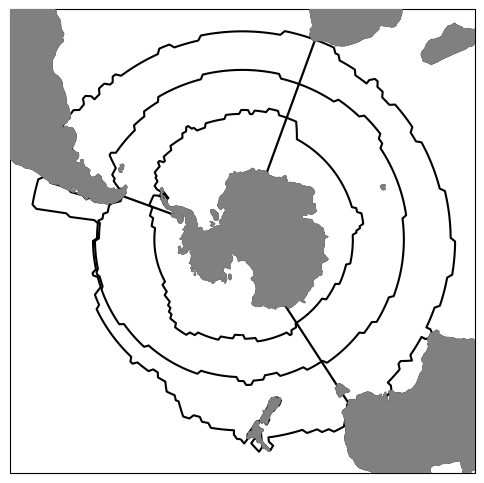

In [9]:
#-----
# test plot for contour lines of biomes
#-------

# lat/lon on RECCAP mesh
lon = np.arange(0.5,359.5+1,1)
lat = np.arange(-89.5,89.5+1,1)

# lon,lat for plotting
xax_X = transform_lon_coord(lon)
xax_X[xax_X>180] = xax_X[xax_X>180]-360 # lon now runs from -179.5:179.5
X, Y  = np.meshgrid(xax_X, lat) 
X = add_cyclic_point(X)
X[:,-1] = 180.5 # -> cannot be -179.5 or the plot will look weird
Y = add_cyclic_point(Y)
    
r_mask = np.copy(regions)
r_mask = transform_lon_coord(regions) 
r_mask = np.ma.masked_where(np.isnan(r_mask),r_mask)
# repeat first element at the end to get rid of grey line in plot
b = np.zeros((180,360+1))
b[:,:-1] = r_mask
b[:,-1] = r_mask[:,0]
r_mask = b

# create the corresponding mask with only 3 regions
r_mask2 = np.zeros_like(r_mask)
r_mask2[r_mask==0]=1
r_mask2[r_mask==3]=1
r_mask2[r_mask==6]=1
r_mask2[r_mask==1]=2
r_mask2[r_mask==4]=2
r_mask2[r_mask==7]=2
r_mask2[r_mask==2]=3
r_mask2[r_mask==5]=3
r_mask2[r_mask==8]=3
r_mask2 = np.ma.masked_where(r_mask2==0,r_mask2)
print(np.unique(r_mask2))
print(np.min(X),np.max(X))

# correct contour lines near Antarctica (don't want it plotted)
r_mask3 = np.copy(r_mask2)
r_mask3[0:23,:]=np.nan
r_mask3[0:26,200:340]=np.nan
r_mask3 = np.ma.masked_where(np.isnan(r_mask3),r_mask3)

#---
# on a map
#---
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()
ax.set_extent([-180,180, -90, -30],ccrs.PlateCarree())

lw = 1.5
cnt=plt.contour(X,Y,r_mask3,levels=[0,1,2,3],colors=['k','k','k'],linewidths=[lw,lw,lw,lw],transform=ccrs.PlateCarree())

plot_lon_lines = True
if plot_lon_lines:
    # draw longitudinal contours: 70W, 20E, 147E
    lw = 1.6
    lon1, lon2 = 20,20
    lat1, lat2 = -70,-35
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = 147,147
    lat1, lat2 = -70,-39
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = -70,-70
    lat1, lat2 = -70,-55
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())

ax.add_feature(cartopy.feature.LAND,color='grey',zorder=50)
plt.show()



In [10]:
#----
# FUNCTIONS
#----

def get_data_plot(data_input,levels):
    # data to plot
    data_plot = np.copy(data_input)
    data_plot = transform_lon_coord(data_plot) 
    b = np.zeros((180,360+1))
    b[:,:-1] = data_plot
    b[:,-1]  = data_plot[:,0]
    data_plot = b
    #------
    mask = (data_plot>levels[-1]) & (data_plot<990)
    data_plot[mask] = levels[-1]
    return data_plot
    
#def plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,lineslonlat,xlin,ylin):
#    color_no_SO = 'gainsboro'
#    map = Basemap(projection='spstere',boundinglat=-30,lon_0=-180,resolution='l',ax=ax)
#    x, y = map(X,Y)
#    #mm=ax.contourf(x, y, data_plot, levels=levels, cmap=colormap, extend='both') 
#    mm=ax.pcolor(x, y, data_plot,vmin=np.min(levels),vmax=np.max(levels),cmap=colormap)
#    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
#    cbar.cmap.set_under(color_no_SO)# color_continents)
#    cbar.remove()
#    fig.canvas.draw_idle() #plt.draw() does not work
#    for lin in range(len(lineslonlat)): # Plot biome boundaries from file with lines:
#        ax.plot(xlin[lin],ylin[lin], color='black', linestyle='-',linewidth=0.1,zorder=1)
#    #map.drawmapboundary(fill_color=color_continents,zorder=30) 
#    map.fillcontinents(color=color_continents,lake_color=color_continents)
#    return mm
    
    
def add_annotations_to_plot(ax,plot_title1,plot_title2,panel_label,fs_text,color_text):
    bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
    #ax.annotate(panel_label+'  ', xy=(0.015,0.94), xycoords='axes fraction',color='black',\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props)
    #ax.annotate(plot_title1, xy=(0.095,0.94), xycoords='axes fraction',color=color_text,\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props) # 0.089
    #ax.annotate(plot_title2, xy=(0.01,0.025), xycoords='axes fraction',color='black',\
    #                    fontweight='bold',fontsize=fs_text+2,bbox=bbox_props)
    ax.annotate(panel_label+'  ', xy=(0.015,1.03), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+3)#,bbox=bbox_props)
    ax.annotate(plot_title1, xy=(0.1,1.03), xycoords='axes fraction',color=color_text,\
                        fontweight='bold',fontsize=fs_text+3)#,bbox=bbox_props) # 0.089
    ax.annotate(plot_title2, xy=(0.025,0.035), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+2,bbox=bbox_props)
    

In [11]:
#-----
# settings for all plots
#-----

dpicnt      = 400
colormap    = cm.RdBu_r

levels      = np.arange(-2,12+1,1)
fs_label    = 14
#fs_text     = 5
fs_text = 12
color_continents = 'grey'
color_no_SO = 'gainsboro'
label_colorbar   = 'FCO$_{2}$ (mol C m$^{-2}$ yr$^{-1}$)'
#label_colorbar   = 'CO$_{2}$ flux in mol C m$^{-2}$ yr$^{-1}$'

color_models      = 'C2'
color_data        = 'C0'
color_data_assim  = 'grey'
color_watson      = 'lightsteelblue'
color_data_assim1 = 'dimgrey'
color_data_assim2 = 'darkgrey'

#colormap =  ListedColormap([(0./255.,119./255.,187./255.),(0./255.,119./255.,187./255.),(0./255.,119./255.,187./255.),\
#                            (221./255.,204./255.,119./255.),(221./255.,204./255.,119./255.),(221./255.,204./255.,119./255.),\
#                            (136./255.,34./255.,85./255.),(136./255.,34./255.,85./255.),(136./255.,34./255.,85./255.),\
#                            (251./255.,154./255.,153./255.),(251./255.,154./255.,153./255.),(251./255.,154./255.,153./255.)]) 
    
## replace teal with blue
colormap =  ListedColormap([(136./255.,34./255.,85./255.),(136./255.,34./255.,85./255.),(136./255.,34./255.,85./255.),\
                            (221./255.,204./255.,119./255.),(221./255.,204./255.,119./255.),(221./255.,204./255.,119./255.),\
                            (0./255.,119./255.,187./255.),(0./255.,119./255.,187./255.),(0./255.,119./255.,187./255.),\
                            (251./255.,154./255.,153./255.),(251./255.,154./255.,153./255.),(251./255.,154./255.,153./255.)])


/tmp/ipykernel_1636223/2396502523.py:40: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cbar.cmap.set_under(color_no_SO)#color_continents)
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


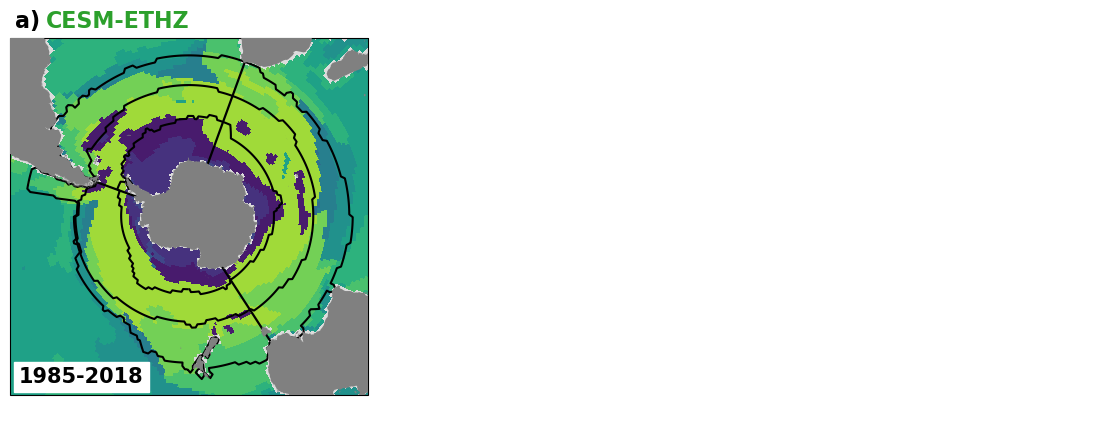

In [12]:
#-----
# test plot
#-----

plot_test = True
if plot_test:

    ii = 1
    
    # data to plot
    data_plot = np.copy(ind_min_flux[:,:,ii])
    #print flux_models.shape
    #print models[3]
    #data_plot = np.copy(-1*factor*flux_models[:,:,3])
    data_plot = transform_lon_coord(data_plot) 
    b = np.zeros((180,360+1))
    b[:,:-1] = data_plot
    b[:,-1]  = data_plot[:,0]
    data_plot = b
    #------
    levels_test      = np.arange(-2,12+1,1)
    mask = (data_plot>levels[-1]) & (data_plot<990)
    data_plot[mask] = levels[-1]
    
    
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
    ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.025)
    
    ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    ax2.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    ax3.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

    ax=ax1
    mm=ax.pcolormesh(X,Y, data_plot,vmin=-1,vmax=13,transform=ccrs.PlateCarree())#, levels=levels_test, cmap=cm.Spectral_r, extend='both') 
    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
    cbar.cmap.set_under(color_no_SO)#color_continents)
    cbar.remove()
    fig.canvas.draw_idle() #plt.draw() does not work
    
    #---
    # plot outlines of biomes
    #---
    lw = 1.5
    cnt=ax1.contour(X,Y,r_mask3,levels=[0,1,2,3],colors=['k','k','k'],linewidths=[lw,lw,lw,lw],transform=ccrs.PlateCarree())
    # draw longitudinal contours: 70W, 20E, 147E
    lw = 1.6
    lon1, lon2 = 20,20
    lat1, lat2 = -70,-35
    ax1.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = 147,147
    lat1, lat2 = -70,-39
    ax1.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = -70,-70
    lat1, lat2 = -70,-55
    ax1.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    
    ax1.add_feature(cfeature.GSHHSFeature('low'), zorder=50, edgecolor=None, facecolor=color_continents)
    ax1.plot([180, 180], [-90, -79],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    ax1.plot([0, 0], [-90, -70.9],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    
    plot_title2a = '1985-2018' # years
    panel_label_a = 'a)'
    plot_title1a = models[ii]
    add_annotations_to_plot(ax1,plot_title1a,plot_title2a,panel_label_a,13,color_models)
    
    ax=ax2
    ax.set_axis_off()
    ax=ax3
    ax.set_axis_off()
    
    plt.show()



In [ ]:
print(np.unique(data_plot))

In [44]:
#---
# FUNCTIONS
#---

def get_data_plot(data_input,levels):
    # data to plot
    data_plot = np.copy(data_input)
    data_plot = transform_lon_coord(data_plot) 
    b = np.zeros((180,360+1))
    b[:,:-1] = data_plot
    b[:,-1]  = data_plot[:,0]
    data_plot = b
    #------
    mask = (data_plot>levels[-1]) & (data_plot<990)
    data_plot[mask] = levels[-1]
    return data_plot

def plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask): #,xlin,ylin): 
    color_no_SO = 'gainsboro'
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    #mm=ax.contourf(X,Y, data_plot, levels=levels, cmap=colormap, extend='both',transform=ccrs.PlateCarree()) 
    #mm=ax.pcolor(X,Y, data_plot,vmin=-1,vmax=13,cmap=colormap,transform=ccrs.PlateCarree())
    #mm=ax.pcolormesh(X,Y, data_plot,vmin=-1,vmax=13,cmap=colormap,transform=ccrs.PlateCarree())
    mm=ax.pcolormesh(X,Y, data_plot,vmin=-1,vmax=10,cmap=colormap,transform=ccrs.PlateCarree())
    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) #fraction=0.075, pad=0.15,shrink=1.0
    cbar.cmap.set_over(color_no_SO)
    cbar.cmap.set_under(color_no_SO)
    cbar.remove()
    fig.canvas.draw_idle() #plt.draw() does not work
    
    #---
    # plot outlines of biomes
    #---
    lw = 1.5
    cnt=ax.contour(X,Y,r_mask,levels=[0,1,2,3],colors=['k','k','k'],linewidths=[lw,lw,lw,lw],transform=ccrs.PlateCarree())
    # draw longitudinal contours: 70W, 20E, 147E
    lw = 1.6
    lon1, lon2 = 20,20
    lat1, lat2 = -70,-35
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = 147,147
    lat1, lat2 = -70,-39
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    lon1, lon2 = -70,-70
    lat1, lat2 = -70,-55
    ax.plot([lon1, lon2], [lat1, lat2],color='k',linewidth=lw,transform=ccrs.Geodetic())
    
    # add continents
    ax.add_feature(cfeature.GSHHSFeature('low'), zorder=50, edgecolor=None, facecolor=color_continents)
    ax.plot([180, 180], [-90, -79],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    ax.plot([0, 0], [-90, -70.9],
                 zorder=3, color=color_continents,
                 linewidth=3,
                 transform=ccrs.PlateCarree()) 
    #ax.add_feature(cartopy.feature.LAND,color=color_continents,zorder=50)
    return mm

def plot_colorbar(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask): #,xlin,ylin): 
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    #mm=ax.contourf(X,Y, data_plot, levels=levels, cmap=colormap, extend='both',transform=ccrs.PlateCarree()) 
    mm=ax.pcolormesh(X,Y, data_plot,vmin=-1,vmax=13,cmap=colormap,transform=ccrs.PlateCarree())
    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05,ticks=[0.35,3.1,5.8,8.75]) #fraction=0.075, pad=0.15,shrink=1.0
    #cbar.cmap.set_over(color_continents)
    #cbar.cmap.set_under(color_no_SO)
    cbar.remove()
    fig.canvas.draw_idle() #plt.draw() does not work
    return mm

def add_annotations_to_plot(ax,plot_title1,plot_title2,panel_label,fs_text,color_text):
    bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
    #ax.annotate(panel_label+'  ', xy=(0.015,0.94), xycoords='axes fraction',color='black',\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props)
    #ax.annotate(plot_title1, xy=(0.095,0.94), xycoords='axes fraction',color=color_text,\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props) # 0.089
    #ax.annotate(plot_title2, xy=(0.01,0.025), xycoords='axes fraction',color='black',\
    #                    fontweight='bold',fontsize=fs_text+2,bbox=bbox_props)
    ax.annotate(panel_label+'  ', xy=(0.015,1.03), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+3)#,bbox=bbox_props)
    ax.annotate(plot_title1, xy=(0.1,1.03), xycoords='axes fraction',color=color_text,\
                        fontweight='bold',fontsize=fs_text+3)#,bbox=bbox_props) # 0.089
    ax.annotate(plot_title2, xy=(0.025,0.035), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text+2,bbox=bbox_props)
    

Data product MEAN...


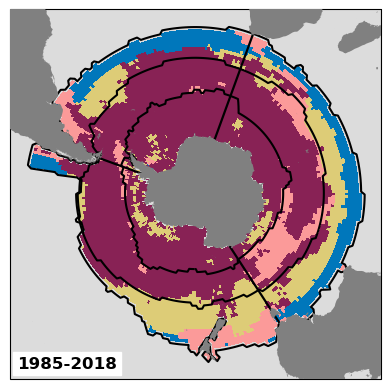

In [46]:
#---
# plot multi-model mean, multi-data product mean
#---

reccap_regions_only = True
save_plots = True
display_plots = True


def add_annotations_to_plot_2(ax,plot_title1,plot_title2,panel_label,fs_text,color_text):
    bbox_props = dict(boxstyle="square,pad=0.25", fc="white", ec="white", lw=1) # fc=frontcolor, ec=edgecolor
    #ax.annotate(panel_label+'  ', xy=(0.015,1.035), xycoords='axes fraction',color='black',\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props) # 0.95
    #ax.annotate(plot_title1, xy=(0.088,1.035), xycoords='axes fraction',color=color_text,\
    #                    fontweight='bold',fontsize=fs_text,bbox=bbox_props)
    ax.annotate(plot_title2, xy=(0.02,0.03), xycoords='axes fraction',color='black',\
                        fontweight='bold',fontsize=fs_text,bbox=bbox_props) #(0.01,0.025)

#------
# DATA PRODUCT MEAN
#-----
print('Data product MEAN...')
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
data_plot = ind_min_flux_data_prod_MEAN[:,:,0]
data_plot[data_plot==11]=-1 # shift "December" in time series -> to have all summer months together
if reccap_regions_only:
    data_plot[regions.mask==True]=-999
data_plot = get_data_plot(data_plot,levels)
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
plot_time_string = str(year1)+'-'+str(year2)
add_annotations_to_plot_2(ax,'pCO$_{2}$-products',plot_time_string,'',fs_text,color_data)
del data_plot 
filename = 'fig_map_timing_max_CO2_uptake_MEAN_DATA_PRODUCTS_1985_2018.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
if display_plots:
    plt.show()
else:
    plt.close(fig)



In [50]:

#fig = plt.figure(figsize=(10,6))
#plt.pcolormesh(data_plot,vmin=-1,vmax=10,cmap=colormap)
#plt.plot(335,30,'kx')
#plt.plot(335,35,'kx')
#plt.plot(335,40,'kx')
#plt.plot(335,45,'kx')
#print(ind_min_flux[30,335,ii])
#print(ind_min_flux[35,335,ii])
#print(ind_min_flux[40,335,ii])
#print(ind_min_flux[45,335,ii])
#plt.ylim((0,60))
#plt.show()


B-SOSE


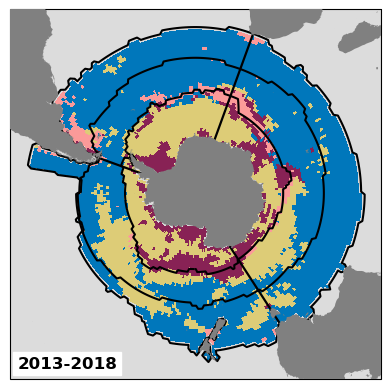

ECCO-DARWIN


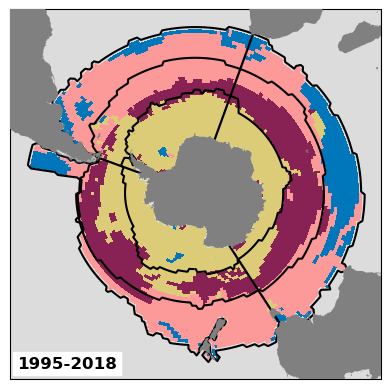

In [47]:

#----
# B-SOSE
#----
print ('B-SOSE')
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
data_plot = ind_min_flux_data_assim[:,:,0]
data_plot[data_plot==11]=-1 # shift "December" in time series -> to have all summer months together
if reccap_regions_only:
    data_plot[regions.mask==True]=-999
data_plot = get_data_plot(data_plot,levels)
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
plot_time_string = '2013-'+str(year2)
add_annotations_to_plot_2(ax,data_assim[0],plot_time_string,'',fs_text,color_data_assim1)
del data_plot
filename = 'fig_map_timing_max_CO2_uptake_DATA_ASSIM_BSOSE_'+plot_time_string.replace("-","_")+'.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
if display_plots:
    plt.show()
else:
    plt.close(fig)
        
#----
# ECCO-DARWIN
#----
print ('ECCO-DARWIN')
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
data_plot = ind_min_flux_data_assim[:,:,1]
data_plot[data_plot==11]=-1 # shift "December" in time series -> to have all summer months together
if reccap_regions_only:
    data_plot[regions.mask==True]=-999
data_plot = get_data_plot(data_plot,levels)
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
plot_time_string = '1995-'+str(year2)
add_annotations_to_plot_2(ax,data_assim[1],plot_time_string,'',fs_text,color_data_assim1)
del data_plot
filename = 'fig_map_timing_max_CO2_uptake_DATA_ASSIM_ECCO-DARWIN_'+plot_time_string.replace("-","_")+'.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
if display_plots:
    plt.show()
else:
    plt.close(fig)
        


LDEO


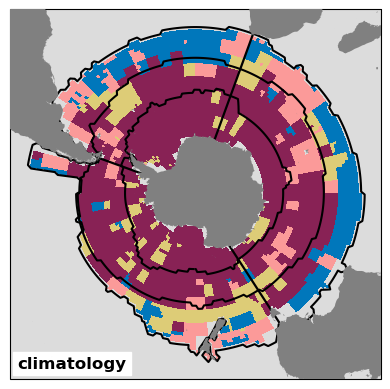

Watson2020


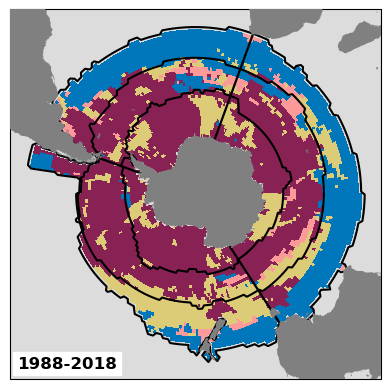

In [48]:

#----
# LDEO
#----
print('LDEO')
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
data_plot = ind_min_flux_ldeo[:,:]
data_plot[data_plot==11]=-1 # shift "December" in time series -> to have all summer months together
if reccap_regions_only:
    data_plot[regions.mask==True]=-999
data_plot = get_data_plot(data_plot,levels)
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
plot_time_string = 'climatology' #str(year1)+'-'+str(year2)
add_annotations_to_plot_2(ax,'LDEO',plot_time_string,'',fs_text,color_data) #'skyblue'
del data_plot
filename = 'fig_map_timing_max_CO2_uptake_DATA_PROD_LDEO_'+plot_time_string+'.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
if display_plots:
    plt.show()
else:
    plt.close(fig)

    
#----
# Watson
#----
print('Watson2020')
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
data_plot = ind_min_flux_watson[:,:,0]
data_plot[data_plot==11]=-1 # shift "December" in time series -> to have all summer months together
if reccap_regions_only:
    data_plot[regions.mask==True]=-999
data_plot = get_data_plot(data_plot,levels)
mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
plot_time_string = '1988-'+str(year2)
add_annotations_to_plot_2(ax,'Watson2020',plot_time_string,'',fs_text,color_data) #'skyblue'
del data_plot
filename = 'fig_map_timing_max_CO2_uptake_DATA_PROD_Watson2020_'+plot_time_string+'.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
if display_plots:
    plt.show()
else:
    plt.close(fig)
    

In [49]:
#---
# plot each model, data product etc. individually
#---

plot_all_models = True
plot_all_data_prod = True

save_plots = True
display_plots = False

if plot_all_models:
    #----
    # all MODELS
    #----
    for ii in range(0,len(models)):
        print (ii,models[ii])
        fig = plt.figure(figsize=(5,6))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
        data_plot = ind_min_flux[:,:,ii]
        data_plot[data_plot==11]=-1 # shift "December" in time series -> to have all summer months together
        if reccap_regions_only:
            data_plot[regions.mask==True]=-999
        data_plot = get_data_plot(data_plot,levels)
        mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
        if models[ii] in ['CCSM-WHOI']:
            plot_time_string = str(year1)+'-2017'
        else:
            plot_time_string = str(year1)+'-'+str(year2)
        add_annotations_to_plot_2(ax,models[ii],plot_time_string,'',fs_text,color_data)
        del data_plot
        filename = 'fig_map_timing_max_CO2_uptake_MODELS_'+models[ii]+'_'+plot_time_string.replace("-","_")+'.png'
        if save_plots: 
            plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
        if display_plots:
            plt.show()
        else:
            plt.close(fig)

if plot_all_data_prod:
    #----
    # all DATA PRODUCTS
    #----
    for ii in range(0,len(data_prod)):
        print (ii,data_prod[ii])
        fig = plt.figure(figsize=(5,6))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
        data_plot = ind_min_flux_data_prod[:,:,ii]
        data_plot[data_plot==11]=-1 # shift "December" in time series -> to have all summer months together
        if reccap_regions_only:
            data_plot[regions.mask==True]=-999
        data_plot = get_data_plot(data_plot,levels)
        mm=plot_map(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask3)
        if data_prod[ii]in ['AOML_EXTRAT']:
            plot_time_string = '1998-'+str(year2)
        else:
            plot_time_string = str(year1)+'-'+str(year2)
        add_annotations_to_plot_2(ax,data_prod[ii],plot_time_string,'',fs_text,color_data)
        del data_plot
        filename = 'fig_map_timing_max_CO2_uptake_DATA_PROD_'+data_prod[ii]+'_'+plot_time_string.replace("-","_")+'.png'
        if save_plots: 
            plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
        if display_plots:
            plt.show()
        else:
            plt.close(fig)
        


0 CCSM-WHOI
1 CESM-ETHZ
2 CNRM-ESM2-1
3 EC-Earth3
4 FESOM_REcoM_HR
5 FESOM_REcoM_LR
6 MOM6-Princeton
7 MPIOM-HAMOCC
8 MRI-ESM2-1
9 NorESM-OC1.2
10 ORCA025-GEOMAR
11 ORCA1-LIM3-PISCES
12 PlankTOM12
13 ROMS-SouthernOcean-ETHZ
0 AOML_EXTRAT
1 CMEMS-LSCE-FFNN
2 CSIRML6
3 JenaMLS
4 JMAMLR
5 LDEO-HPD
6 NIES-ML3
7 OceanSODAETHZ
8 SOMFFN


In [ ]:
#-----
# COLORBAR: plot separately
#-----
print('Separate COLORBAR...')

def plot_colorbar(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask): #,xlin,ylin): 
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    mm=ax.pcolor(X,Y, data_plot,vmin=-1,vmax=13,cmap=colormap,transform=ccrs.PlateCarree())
    cbar=plt.colorbar(mm, ax=ax,orientation='horizontal',shrink=0.5,pad=0.05) 
    #cbar.cmap.set_over(color_continents)
    #cbar.cmap.set_under(color_no_SO)
    cbar.remove()
    fig.canvas.draw_idle() #plt.draw() does not work
    return mm

cticks_label = ['DJF','MAM','JJA','SON']

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
data_plot = ind_min_flux_data_prod_MEAN[:,:,0]
data_plot[data_plot==11]=-1 # shift "December" in time series -> to have all summer months together
if reccap_regions_only:
    data_plot[regions.mask==True]=-999
data_plot = get_data_plot(data_plot,levels)
mm=plot_colorbar(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask)
fig.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.1])
cbar=fig.colorbar(mm,cax=cax,orientation='horizontal',ticks=[0.75,4.25,7.75,11.25])#,fraction=0.075, shrink=1.0)#pad=0.15,cax=cbar_ax, 
cbar.set_label('Season of maximum CO$_{2}$ uptake',fontsize=fs_text+3)
cbar.ax.tick_params(labelsize=fs_text+4)
cbar.ax.set_xticklabels(cticks_label)

filename = 'fig_map_timing_max_CO2_uptake_COLORBAR.png'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False)     
    
plt.show()


In [ ]:
#---
# SEPARATE COLORBAR EPS
#---
print('Separate COLORBAR, EPS...')
cticks_label = []

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #projection=ccrs.PlateCarree())
data_plot = ind_min_flux_data_prod_MEAN[:,:,0]
data_plot[data_plot==11]=-1 # shift "December" in time series -> to have all summer months together
if reccap_regions_only:
    data_plot[regions.mask==True]=-999
data_plot = get_data_plot(data_plot,levels)
plot_colorbar(ax,X,Y,data_plot,levels,colormap,color_continents,r_mask)
fig.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.1])
cbar=fig.colorbar(mm,cax=cax,orientation='horizontal',ticks=[0.75,4.25,7.75,11.25])
cbar.ax.tick_params(labelsize=fs_text+4)
cbar.ax.set_xticklabels(cticks_label)
    
filename = 'fig_map_timing_max_CO2_uptake_COLORBAR.eps'
if save_plots: 
    plt.savefig(save_to_dir+filename, bbox_inches='tight',dpi=dpicnt, transparent=False,format='eps')     
    
plt.show()


In [ ]:
print(save_to_dir)